# Importons les bibliotehques necessaire

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from pyDeepInsight import ImageTransformer, LogScaler
from keras.callbacks import EarlyStopping
import time

2023-12-16 00:49:56.930200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
df_ = pd.read_csv('FlowStatsfiles.csv', low_memory=False)

In [13]:
df_ = pd.read_csv('PortStatsfile.csv')

## Partie 1 : Analyse des données

In [10]:
df.head()

NameError: name 'df' is not defined

In [23]:
df_.shape

(194195, 23)

In [3]:
print(df_[(df_['protocole'] == 'ICMP') & (df_['bytecount'] == 0)])

           timestamp  datapath                           flow_id  in_port  \
10      1.702041e+09         1   172.24.16.1836640172.24.16.5443        1   
15      1.702041e+09         1   172.24.16.233650172.24.16.19443        2   
25      1.702041e+09         1  172.24.16.35051172.24.16.2737369        3   
28      1.702041e+09         1  172.24.16.537369172.24.16.185051        3   
32      1.702041e+09         6          172.24.16.10172.24.16.40        1   
...              ...       ...                               ...      ...   
211500  1.702044e+09         5   96.206.82.1041389172.24.16.2580        5   
211501  1.702044e+09         5  98.115.232.2001389172.24.16.2580        5   
211502  1.702044e+09         5   99.11.124.1631389172.24.16.2580        5   
211503  1.702044e+09         5  99.250.255.1681389172.24.16.2580        5   
211504  1.702044e+09         5   99.32.142.2351389172.24.16.2580        5   

        eth_type            eth_src            eth_dst          ip_src  \
1

In [6]:
# Supprimer toutes les lignes où le protocole est "ICMP" et la colonne "bytecount" est égale à 0
df_ = df_.loc[~((df_['protocole'] == 'ICMP') & (df_['bytecount'] == 0))]

In [7]:
# Supprimer toutes les lignes où le protocole est "ICMP" et la colonne "bytecount" est égale à 0 dans la DataFrame existante
df_.drop(df_[(df_['protocole'] == 'ICMP') & ((df_['bytecount'] == 0) | (df_['pktcount'] == 0)) & (df_['label'] == 0)].index, inplace=True)
df_.drop(df_[(df_['protocole'] == 'UDP') & ((df_['bytecount'] == 0) | (df_['pktcount'] == 0)) & (df_['label'] == 0)].index, inplace=True)
df_.drop(df_[(df_['protocole'] == 'TCP') & ((df_['bytecount'] == 0) | (df_['pktcount'] == 0)) & (df_['label'] == 0)].index, inplace=True)

In [8]:
df_.shape

(294829, 23)

In [9]:
df_.to_csv('FlowState.csv', index=False)

In [24]:
df_ = pd.read_csv('FlowState.csv')

/tmp/ipykernel_213783/1186817044.py:1: DtypeWarning: Columns (19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv('FlowState.csv')


In [6]:
print(df_[(df_['protocole'] == 'ICMP') & (df_['bytecount'] == 0)])

Empty DataFrame
Columns: [timestamp, datapath, flow_id, in_port, eth_type, eth_src, eth_dst, ip_src, tp_src, ip_dst, tp_dst, icmp_code, icmp_type, protocole, pktcount, bytecount, flowdur_sec, flowdur_nsec, pktcount_sec, pktcount_nsec, bytecount_sec, bytecount_nsec, label]
Index: []

[0 rows x 23 columns]


In [17]:
df_

,timestamp,datapath,flow_id,in_port,eth_type,eth_src,eth_dst,ip_src,tp_src,ip_dst,...,protocole,pktcount,bytecount,flowdur_sec,flowdur_nsec,pktcount_sec,pktcount_nsec,bytecount_sec,bytecount_nsec,label
0,1.702643e+09,5,172.24.16.20172.24.16.10,1,2048,06:ad:7d:c1:dc:1b,0a:b1:b5:23:aa:ad,172.24.16.2,0,172.24.16.1,...,ICMP,1,98,0,371000000,0.000000,0.000000e+00,0.000000,0.000000,0
1,1.702643e+09,5,172.24.16.30172.24.16.40,5,2048,a2:5c:46:f2:34:27,20:77:6d:b7:70:8a,172.24.16.3,0,172.24.16.4,...,ICMP,46,4508,63,769000000,0.730159,5.981795e-08,71.555556,0.000006,0
2,1.702643e+09,5,172.24.16.40172.24.16.30,3,2048,20:77:6d:b7:70:8a,a2:5c:46:f2:34:27,172.24.16.4,0,172.24.16.3,...,ICMP,46,4508,63,758000000,0.730159,6.068602e-08,71.555556,0.000006,0
3,1.702643e+09,2,172.24.16.30172.24.16.40,3,2048,a2:5c:46:f2:34:27,20:77:6d:b7:70:8a,172.24.16.3,0,172.24.16.4,...,ICMP,46,4508,63,757000000,0.730159,6.076618e-08,71.555556,0.000006,0
4,1.702643e+09,2,172.24.16.40172.24.16.30,2,2048,20:77:6d:b7:70:8a,a2:5c:46:f2:34:27,172.24.16.4,0,172.24.16.3,...,ICMP,46,4508,63,752000000,0.730159,6.117021e-08,71.555556,0.000006,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215414,1.702685e+09,2,97.49.214.283147172.24.16.2580,3,2048,7c:0b:8a:84:5c:23,7c:0b:8a:84:5c:23,97.49.214.28,3147,172.24.16.25,...,UDP,0,0,0,239000000,0.000000,0.000000e+00,0.000000,0.000000,1
215415,1.702685e+09,2,97.97.49.1205100172.24.16.2580,3,2048,7c:0b:8a:84:5c:23,7c:0b:8a:84:5c:23,97.97.49.120,5100,172.24.16.25,...,UDP,0,0,2,557000000,0.000000,0.000000e+00,0.000000,0.000000,1
215416,1.702685e+09,2,98.109.209.565020172.24.16.2580,3,2048,7c:0b:8a:84:5c:23,7c:0b:8a:84:5c:23,98.109.209.56,5020,172.24.16.25,...,UDP,0,0,2,656000000,0.000000,0.000000e+00,0.000000,0.000000,1
215417,1.702685e+09,2,98.120.7.792653172.24.16.2580,3,2048,7c:0b:8a:84:5c:23,7c:0b:8a:84:5c:23,98.120.7.79,2653,172.24.16.25,...,UDP,0,0,2,267000000,0.000000,0.000000e+00,0.000000,0.000000,1


In [12]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191826 entries, 0 to 191825
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       191826 non-null  float64
 1   datapath        191826 non-null  int64  
 2   flow_id         191826 non-null  object 
 3   in_port         191826 non-null  int64  
 4   eth_type        191826 non-null  int64  
 5   eth_src         191826 non-null  object 
 6   eth_dst         191826 non-null  object 
 7   ip_src          191826 non-null  object 
 8   tp_src          191826 non-null  int64  
 9   ip_dst          191826 non-null  object 
 10  tp_dst          191826 non-null  int64  
 11  icmp_code       191826 non-null  int64  
 12  icmp_type       191826 non-null  int64  
 13  protocole       191826 non-null  object 
 14  pktcount        191826 non-null  int64  
 15  bytecount       191826 non-null  int64  
 16  flowdur_sec     191826 non-null  int64  
 17  flowdur_ns

In [4]:
df_.label.unique()

array([0, 1])

In [27]:
df_.label.value_counts()

1    80482
0    68008
Name: label, dtype: int64

In [30]:
df_.protocole.value_counts()

ICMP    48389
TCP     45158
UDP     43219
Name: protocole, dtype: int64

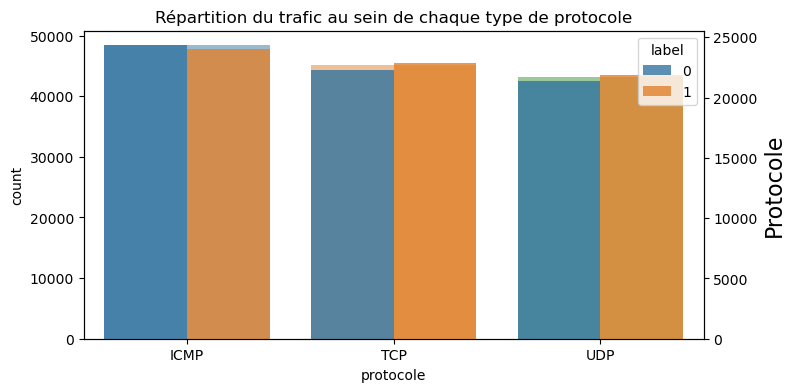

In [31]:
plt.figure(figsize=(8,4))
plt.title("Répartition du trafic au sein de chaque type de protocole")
g1 = sns.countplot(x='protocole', data=df_,alpha=0.5)
gt = g1.twinx()
gt = sns.countplot(x='protocole', hue='label',alpha=0.8, data=df_)
gt.set_ylabel('Protocole', fontsize=16)
plt.savefig('Protocole.png')

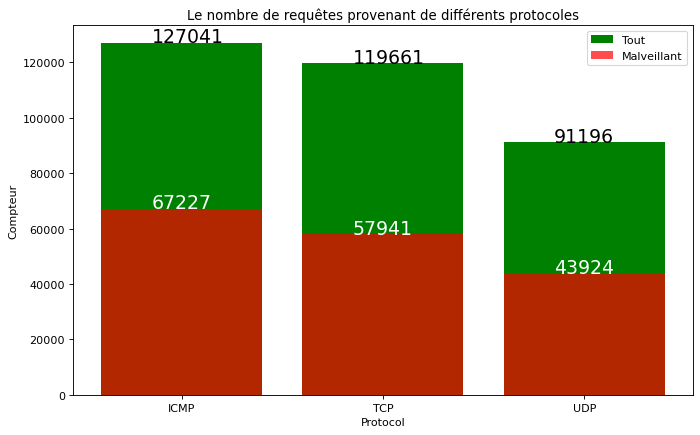

In [13]:
all_counts = df_['protocole'].value_counts().tolist()
malicious_counts = df_[df_['label'] == 1]['protocole'].value_counts().tolist()
#normal_counts = df_[df_['label'] == 0]['Protocol'].value_counts().tolist()
protocols = df_['protocole'].value_counts().index.tolist()


fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

bar1 = ax.bar(protocols, all_counts, color='g', label='Tout')

bar2 = ax.bar(protocols, malicious_counts, color='r', label='Malveillant', alpha=0.7)

#bar3 = ax.bar(protocols, normal_counts, color='b', label='Normal', alpha=0.5)

for i, bar in enumerate(bar1):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 200, str(all_counts[i]), color='black', size=17)

for i, bar in enumerate(bar2):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 200, str(malicious_counts[i]), color='w', size=17)

#for i, bar in enumerate(bar3):
#    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 200, str(normal_counts[i]), color='r', size=17)

ax.set_xlabel('Protocol')
ax.set_ylabel('Compteur')
ax.legend()

ax.set_title('Le nombre de requêtes provenant de différents protocoles')

plt.show()

In [11]:
df_.isna().sum()

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

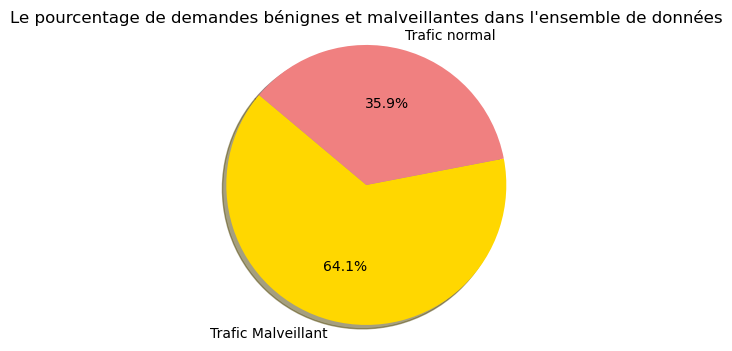

In [38]:
labels = ("Trafic Malveillant", "Trafic normal")
sizes = [len(df_[df_["label"]== 1]), len(df_[df_["label"]== 0])]

colors = ['gold', 'lightcoral']

plt.figure(figsize=(8, 4))
plt.title("Le pourcentage de demandes bénignes et malveillantes dans l'ensemble de données")
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.savefig("Pourcentage_bénignes_&_malveillantes")

In [15]:
plt.figure(figsize=(8, 4), dpi=80)
plt.hist(df_.dur, bins=20, color='b')
plt.title('Durée de flux par second')
plt.savefig("Duree_S.png")

AttributeError: 'DataFrame' object has no attribute 'dur'

<Figure size 640x320 with 0 Axes>

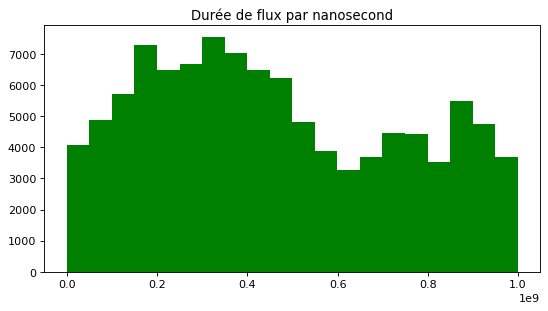

In [14]:
plt.figure(figsize=(8, 4), dpi=80)
plt.hist(df_.dur_nsec, bins=20, color='g')
plt.title('Durée de flux par nanosecond')
plt.savefig("Duree_Ns.png")

Text(0.5, 1.0, 'Caractéristiques qui ont des valeurs NuLL')

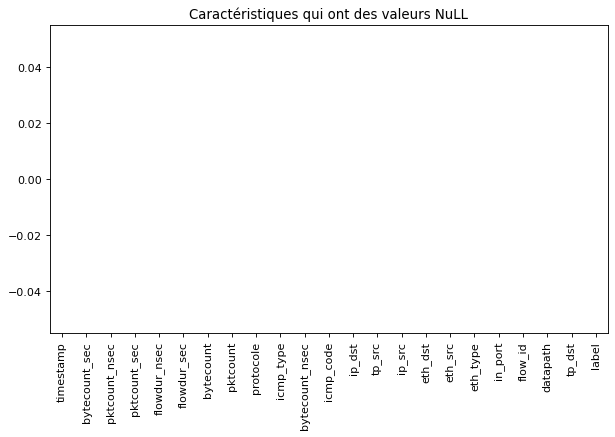

In [16]:
# Let's look at the vizualisation of Null valued features
plt.figure(figsize=(9, 5), dpi=80)
df_[df_.columns[df_.isna().sum() >= 0]].isna().sum().sort_values().plot.bar()
plt.title("Caractéristiques qui ont des valeurs NuLL")

## Partie 2 : Prétraitement des données

#### Gérons toutes les valeurs nulle ou du type *NaN*

In [6]:
df_.dropna(inplace=True)

In [7]:
df_.shape

(32817, 12)

#### Supprimons toutes les informations inutiles

In [18]:
df_.drop(['dt', 'switch', 'src', 'dst','port_no'], axis=1, inplace=True)

In [8]:
df_['class'] = df_['label']
del df_['label']

#### Créons des variables factices pour la colonne Protocole

In [2]:
df_.Protocol.unique()

NameError: name 'df_' is not defined

In [11]:
df_ = pd.get_dummies(df_)
df_.head()

,timestamp,datapath,rx-pkts,rx-bytes,rx-error,rx_dropped,tx-pkts,tx-bytes,tx-error,tx_dropped,duration_nsec,class
0,1.702158e+09,10,9,822,0,0,131,16582,0,0,4,0
1,1.702158e+09,10,11,942,0,0,128,16352,0,0,4,0
2,1.702158e+09,10,120,15122,0,0,19,2328,0,0,4,0
3,1.702158e+09,10,0,0,0,112,0,0,0,0,4,0
4,1.702158e+09,2,109,13786,0,0,36,4566,0,0,3,0


#### Appliquons une échelle MinMax pour normaliser notre ensemble de données et faire en sorte que toutes les valeurs soient comprises dans l'intervalle (0,1).

In [9]:
scaler = preprocessing.MinMaxScaler()
df_nrm= scaler.fit_transform(df_)

In [10]:
df_nv = pd.DataFrame(df_nrm, columns=df_.columns)
df_nv.head()

,timestamp,datapath,rx-pkts,rx-bytes,rx-error,rx_dropped,tx-pkts,tx-bytes,tx-error,tx_dropped,duration_nsec,class
0,0.000000e+00,0.473684,3.174885e-07,8.480693e-10,0.0,0.000000,4.621222e-06,1.710789e-08,0.0,0.0,0.001521,0.0
1,0.000000e+00,0.473684,3.880415e-07,9.718750e-10,0.0,0.000000,4.515392e-06,1.687059e-08,0.0,0.0,0.001521,0.0
2,0.000000e+00,0.473684,4.233180e-06,1.560159e-08,0.0,0.000000,6.702535e-07,2.401831e-09,0.0,0.0,0.001521,0.0
3,0.000000e+00,0.473684,0.000000e+00,0.000000e+00,0.0,0.022825,0.000000e+00,0.000000e+00,0.0,0.0,0.001521,0.0
4,2.194429e-08,0.052632,3.845139e-06,1.422322e-08,0.0,0.000000,1.269954e-06,4.710808e-09,0.0,0.0,0.001141,0.0


In [11]:
df_nv.shape

(32817, 12)

#### Divisons notre ensemble de données en variables d'entrée X et de sortie Y.

In [15]:
X = df_nv.iloc[:,1:17].astype(float)
y = df_nv.iloc[:,-3]

In [12]:
X = df_nv.drop('class', axis=1).astype(float)
y = df_nv['class']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Partie 3 : Mise en place des modèles d'apprentissage

## I : Modèle de Machine Learning

### 1. Modèle de régression logistique

In [14]:
# Paramètres du modèle
C_value = 0.03
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

results_lr = []

start_time = time.time()
best_accuracy = 0
best_solver = None

for solver in solvers:
    # Entraînement du modèle
    LR = LogisticRegression(C=C_value, solver=solver).fit(X_train, y_train)
    predicted_lr = LR.predict(X_test)
    accuracy_lr = accuracy_score(y_test, predicted_lr)
    
    results_lr.append({
        'solver': solver,
        'accuracy': f'{accuracy_lr * 100:.2f}%',
        'coefficients': {'W': LR.coef_, 'b': LR.intercept_}
    })

    if accuracy_lr > best_accuracy:
        best_accuracy = accuracy_lr
        best_solver = solver

# Entraînement final avec le meilleur solveur
LR = LogisticRegression(C=C_value, solver=best_solver).fit(X_train, y_train)
predicted_lr = LR.predict(X_test)
accuracy_lr = accuracy_score(y_test, predicted_lr)

# Affichage des résultats
print(f"Précision: {accuracy_lr * 100:.2f}%\n")
print("########################################################################")
print('Meilleur solveur :', best_solver)
print("########################################################################")
print(classification_report(predicted_lr, y_test), '\n')
print("########################################################################")
print(f"--- {time.time() - start_time:.2f} secondes --- temps pour la régression logistique")


Précision: 88.25%

########################################################################
Meilleur solveur : newton-cg
########################################################################
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94      6562
         1.0       0.00      0.00      0.00         2

    accuracy                           0.88      6564
   macro avg       0.50      0.44      0.47      6564
weighted avg       1.00      0.88      0.94      6564
 

########################################################################
--- 0.43 secondes --- temps pour la régression logistique


### 2. Modèle d'arbre de décision avec recherche des meilleurs hyperparamètres

In [28]:
def train_decision_tree(X_train, y_train, X_test, y_test):
    start_time = time.time()
    tree = DecisionTreeClassifier()
    
    # Recherche des hyperparamètres optimaux
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    }
    
    dt_search = GridSearchCV(tree, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy', verbose=2)
    dt_search.fit(X_train, y_train)
    
    criterion = dt_search.best_params_['criterion']
    max_depth = dt_search.best_params_['max_depth']
    max_leaf_nodes = dt_search.best_params_['max_leaf_nodes']
    
    # Entraînement du modèle avec les hyperparamètres optimaux
    dtree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
    dtree.fit(X_train, y_train)
    
    # Prédiction et évaluation du modèle
    predicted_dt = dtree.predict(X_test)
    accuracy_dt = accuracy_score(y_test, predicted_dt)
    
    # Stockage des résultats
    results = {
        'criterion': criterion,
        'max_depth': max_depth,
        'max_leaf_nodes': max_leaf_nodes,
        'accuracy': round(accuracy_dt * 100, 2)
    }
    
    # Affichage des résultats
    print(f"criterion: {criterion}, max depth: {max_depth}, max_leaf: {max_leaf_nodes}")
    print(f"La précision est : {results['accuracy']}%")
    print("########################################################################")
    print(classification_report(predicted_dt, y_test))
    print("########################################################################")
    
    print("--- %s secondes --- temps pour l'arbre de décision " % (time.time() - start_time))
    
    return results

# Exemple d'utilisation
results = train_decision_tree(X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=4; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=5; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=5; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=6; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=7; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=8; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=9; total time=   0.2s
[CV] END .....criterion=gini, max_depth=2, max

[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=4; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=4; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=5; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=6; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=7; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=7; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=8; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=9; total time=   0.2s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=9; total time=   0.2s
[CV] END .....criterion=gini, max_depth=2, max_leaf_nodes=10; total time=   0.2s
[CV] END .....criterion=gini

[CV] END .....criterion=gini, max_depth=9, max_leaf_nodes=11; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=2; total time=   0.2s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=3; total time=   0.2s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=4; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=5; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=6; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=6; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=7; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=8; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=9; total time=   0.4s
[CV] END ....criterion=gini, max_depth=10, max_leaf_nodes=10; total time=   0.4s
[CV] END ....criterion=gini, max_depth=10, max_leaf_nodes=10; total time=   0.3s
[CV] END ....criterion=gini,

[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=4; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=5; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=6; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=7; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=8; total time=   0.3s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=8; total time=   0.4s
[CV] END .....criterion=gini, max_depth=10, max_leaf_nodes=9; total time=   0.4s
[CV] END ....criterion=gini, max_depth=10, max_leaf_nodes=10; total time=   0.6s
[CV] END ....criterion=gini, max_depth=10, max_leaf_nodes=11; total time=   0.4s
[CV] END ...criterion=entropy, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=2, max_leaf_nodes=3; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ...criterion=entrop

criterion: gini, max depth: 7, max_leaf: 11
La précision est : 99.67%
########################################################################
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12594
         1.0       1.00      0.99      1.00      8174

    accuracy                           1.00     20768
   macro avg       1.00      1.00      1.00     20768
weighted avg       1.00      1.00      1.00     20768

########################################################################
--- 69.09700727462769 secondes --- temps pour l'arbre de décision 


### Forêt aléatoire

In [45]:
start_time = time.time()

# Définissez la grille d'hyperparamètres à explorer
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt']
}

# Créez le modèle RandomForestClassifier
RF = RandomForestClassifier(criterion='gini', oob_score=True, random_state=1, n_jobs=-1)

# Utilisons GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Obtenir les meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_

# Entraînez un modèle RandomForest avec les meilleurs hyperparamètres
RF_best = RandomForestClassifier(criterion='gini', oob_score=True, random_state=1, n_jobs=-1, **best_params)
RF_best.fit(X_train, y_train)

# Prédisez les étiquettes
predicted_rf = RF_best.predict(X_test)
accuracy_rf = accuracy_score(y_test, predicted_rf)

# Affichage des résultats
print(f"Random Forest Précision: {round(accuracy_rf * 100, 2)}%")
print(f"Meilleurs hyperparamètres : {best_params}")
print(classification_report(predicted_rf, y_test))
#print(f"Time for Random Forest: {time.time() - start_time} seconds")
print("--- %s secondes --- temps pour le Random Forest " % (time.time() - start_time))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Précision: 100.0%
Meilleurs hyperparamètres : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12642
         1.0       1.00      1.00      1.00      8126

    accuracy                           1.00     20768
   macro avg       1.00      1.00      1.00     20768
weighted avg       1.00      1.00      1.00     20768

--- 1354.8403310775757 secondes --- temps pour le Random Forest 


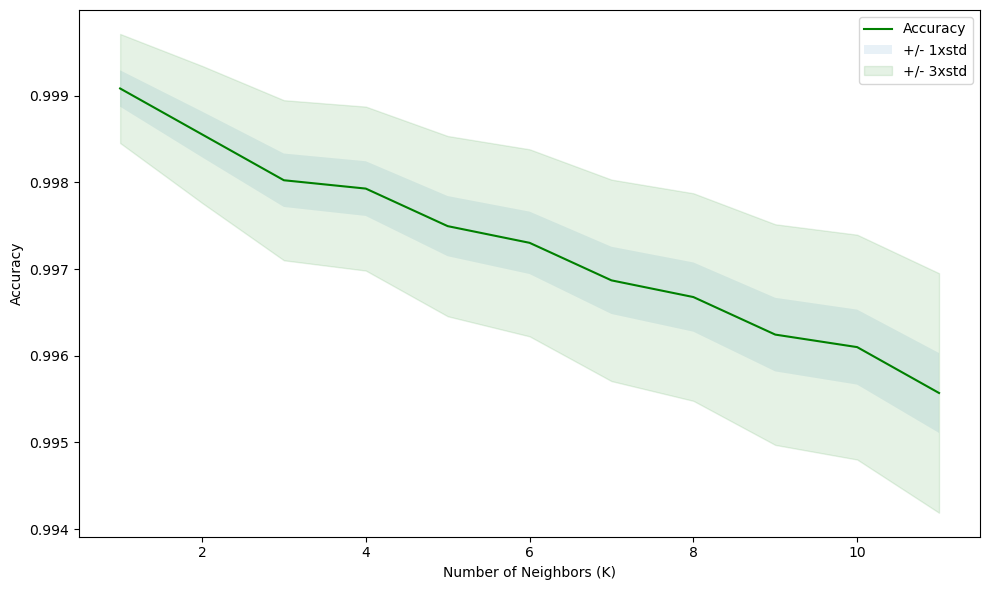

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Précision du model KNN : 99.95%
Meilleur hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12639
         1.0       1.00      1.00      1.00      8129

    accuracy                           1.00     20768
   macro avg       1.00      1.00      1.00     20768
weighted avg       1.00      1.00      1.00     20768

--- 345.596218585968 secondes --- temps pour le KNN model 
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  12.1s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=  12.2s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=  11.2s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=  12.5s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=  43.8s
[CV] END ..metric=manhatt

In [44]:
start_time = time.time()
Ks = 12
accuracy_knn = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1, Ks):
    # Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    accuracy_knn[n-1] = accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(range(1, Ks), accuracy_knn, 'g')
plt.fill_between(range(1, Ks), accuracy_knn - 1 * std_acc, accuracy_knn + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1, Ks), accuracy_knn - 3 * std_acc, accuracy_knn + 3 * std_acc, alpha=0.10, color="green")
plt.legend(('Accuracy', '+/- 1xstd', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# Optimization of k-NN hyperparameters using GridSearchCV
knnc = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knnc_search = GridSearchCV(knnc, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=2)
knnc_search.fit(X_train, y_train)

best_params = knnc_search.best_params_
n_neighbors = best_params['n_neighbors']
weights = best_params['weights']
metric = best_params['metric']

KNN = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
KNN.fit(X_train, y_train)

predicted_knn = KNN.predict(X_test)
accuracy_knn = accuracy_score(y_test, predicted_knn)

# Display results
print(f"Précision du model KNN : {round(accuracy_knn * 100, 2)}%")
print("Meilleur hyperparameters:", best_params)
print(classification_report(predicted_knn, y_test))
#print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s secondes --- temps pour le KNN model " % (time.time() - start_time))


#### Comparaison de performances de différents modèles d'apprentissage automatique à l'aide de la validation croisée

In [31]:
def compare_models():
        models = [
            ("RandomForest", RandomForestClassifier()),
            ("LogisticRegression", LogisticRegression(max_iter=250)),
            ("DecisionTreeClassifier", DecisionTreeClassifier()),
            ("KNeighborsClassifier", KNeighborsClassifier()),
        ]

        model_comps = []

        for model_name, model in models:
            accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy')
            for fold, accuracy in enumerate(accuracies):
                model_comps.append((model_name, fold, accuracy))
        
        return model_comps
compare_models()

[('RandomForest', 0, 0.999879626843214),
 ('RandomForest', 1, 1.0),
 ('RandomForest', 2, 1.0),
 ('RandomForest', 3, 1.0),
 ('RandomForest', 4, 1.0),
 ('LogisticRegression', 0, 0.9463737586518206),
 ('LogisticRegression', 1, 0.9452871072589383),
 ('LogisticRegression', 2, 0.9431804502227037),
 ('LogisticRegression', 3, 0.9460695798723968),
 ('LogisticRegression', 4, 0.9417960755988924),
 ('DecisionTreeClassifier', 0, 0.999879626843214),
 ('DecisionTreeClassifier', 1, 1.0),
 ('DecisionTreeClassifier', 2, 1.0),
 ('DecisionTreeClassifier', 3, 1.0),
 ('DecisionTreeClassifier', 4, 1.0),
 ('KNeighborsClassifier', 0, 0.9972916039723142),
 ('KNeighborsClassifier', 1, 0.9972312507523775),
 ('KNeighborsClassifier', 2, 0.9965089683399543),
 ('KNeighborsClassifier', 3, 0.997351631154448),
 ('KNeighborsClassifier', 4, 0.9969302997472012)]

## II : Model de Deep Learning 

In [46]:
# Créez un modèle séquentiel
model = Sequential()

# Couche d'entrée
model.add(Dense(128, input_shape=(16,), activation='relu'))

# Couches cachées profondes
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Couche de sortie
model.add(Dense(1, activation='sigmoid'))

# Compilez le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               2176      
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                      

[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  10.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  28.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=  49.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=  51.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  28.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500; total time=  49.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=   8.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=   9.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  29.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=

In [33]:
# Ce rappel arrêtera la formation lorsqu'il n'y aura pas d'amélioration de la perte de validation pendant 5 époques consécutives.  
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=5,
    restore_best_weights=True
)

In [34]:
model.compile(loss='binary_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [35]:
model.fit(X_train, 
          y_train, 
          epochs=30,
          batch_size=255, 
          verbose=1, 
          validation_split=0.3,
          callbacks=[es])

Epoch 1/30
229/229 [==============================] - 10s 37ms/step - loss: 0.1222 - accuracy: 0.9529 - val_loss: 0.4413 - val_accuracy: 0.7714
Epoch 2/30
229/229 [==============================] - 8s 35ms/step - loss: 0.0460 - accuracy: 0.9844 - val_loss: 0.1608 - val_accuracy: 0.9303
Epoch 3/30
229/229 [==============================] - 9s 38ms/step - loss: 0.0289 - accuracy: 0.9904 - val_loss: 0.0186 - val_accuracy: 0.9943
Epoch 4/30
229/229 [==============================] - 8s 36ms/step - loss: 0.0257 - accuracy: 0.9911 - val_loss: 0.0203 - val_accuracy: 0.9925
Epoch 5/30
229/229 [==============================] - 9s 38ms/step - loss: 0.0280 - accuracy: 0.9908 - val_loss: 0.0156 - val_accuracy: 0.9945
Epoch 6/30
229/229 [==============================] - 8s 34ms/step - loss: 0.0174 - accuracy: 0.9936 - val_loss: 0.0133 - val_accuracy: 0.9946
Epoch 7/30
229/229 [==============================] - 9s 39ms/step - loss: 0.0174 - accuracy: 0.9939 - val_loss: 0.0361 - val_accuracy: 0.989

 74/229 [========>.....................] - ETA: 13:40:54 - loss: 0.0107 - accuracy: 0.9957[CV] END ..criterion=entropy, max_depth=8, max_leaf_nodes=11; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=2; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=2; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=3; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=3; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=4; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=5; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=6; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=7; total time=   0.4s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=8; total time=   0.5s
[CV] END ...criterion=entropy, max_depth=9, max_leaf_nodes=8; total time=   0.3s
[CV] END ...criteri

229/229 [==============================] - 23204s 102s/step - loss: 0.0106 - accuracy: 0.9958 - val_loss: 0.0061 - val_accuracy: 0.9980
Epoch 18/30
229/229 [==============================] - 9s 37ms/step - loss: 0.0100 - accuracy: 0.9963 - val_loss: 0.0087 - val_accuracy: 0.9966
Epoch 19/30
229/229 [==============================] - 8s 35ms/step - loss: 0.0093 - accuracy: 0.9962 - val_loss: 0.0132 - val_accuracy: 0.9946
Epoch 20/30
229/229 [==============================] - 10s 45ms/step - loss: 0.0132 - accuracy: 0.9949 - val_loss: 0.0084 - val_accuracy: 0.9963
Epoch 21/30
229/229 [==============================] - 11s 46ms/step - loss: 0.0095 - accuracy: 0.9962 - val_loss: 0.0093 - val_accuracy: 0.9963
Epoch 22/30
229/229 [==============================] - 9s 38ms/step - loss: 0.0097 - accuracy: 0.9964 - val_loss: 0.0051 - val_accuracy: 0.9983
Epoch 23/30
229/229 [==============================] - 9s 38ms/step - loss: 0.0104 - accuracy: 0.9961 - val_loss: 0.0401 - val_accuracy: 0.986

229/229 [==============================] - 9s 41ms/step - loss: 0.0076 - accuracy: 0.9974 - val_loss: 0.0081 - val_accuracy: 0.9959
Epoch 28/30
229/229 [==============================] - 9s 39ms/step - loss: 0.0074 - accuracy: 0.9972 - val_loss: 0.0056 - val_accuracy: 0.9977
Epoch 29/30
229/229 [==============================] - 9s 38ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.0078 - val_accuracy: 0.9972
Epoch 30/30
229/229 [==============================] - 9s 38ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.0055 - val_accuracy: 0.9971


In [36]:
history_dict = model.history.history

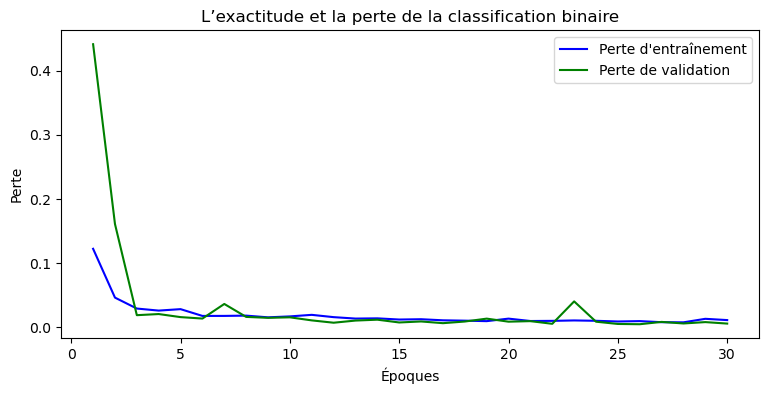

In [54]:
# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1) 

# plot
plt.figure(figsize=(9, 4))
plt.plot(epochs, loss_values, 'blue',label="Perte d'entraînement")
plt.plot(epochs, val_loss_values, 'green', label='Perte de validation')
plt.title("L’exactitude et la perte de la classification binaire")
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.savefig('perte.png')

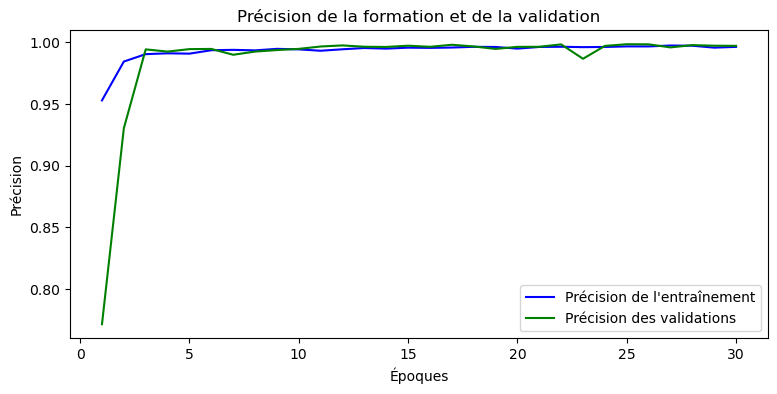

In [55]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(9, 4))
plt.plot(epochs, acc, 'blue',label="Précision de l'entraînement")
# orange is for "orange"
plt.plot(epochs, val_acc, 'green', label='Précision des validations')
plt.title('Précision de la formation et de la validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.savefig('Précision.png')

In [39]:
results = model.evaluate(X_test, y_test, batch_size=250)
print(f"Précision de l'ensemble de tests = {results[1]*100} %")

84/84 [==============================] - 1s 9ms/step - loss: 0.0055 - accuracy: 0.9982
Précision de l'ensemble de tests = 99.82184171676636 %


In [40]:
preds = np.round(model.predict(X_test),0)

print(confusion_matrix(y_test, preds)) 

649/649 [==============================] - 3s 5ms/step
[[12624    18]
 [   19  8107]]


In [41]:
features = 16
model = Sequential()

# Couche d'entrée LSTM
model.add(LSTM(128, input_shape=(None, features), return_sequences=True, activation='relu'))

# Couches cachées LSTM profondes
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(512, return_sequences=True, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Couche de sortie
model.add(Dense(1, activation='sigmoid'))

# Compilez le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         394240    
                                                                 
 batch_normalization_4 (Batc  (None, None, 256)        1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_2 (LSTM)               (None, None, 512)         1574912   
                                                                 
 batch_normalization_5 (Batc  (None, None, 512)        2048      
 hNormalization)                                      